### Comparing the VEP versions between Sakina (online editor) and Thiago's (downloaded VEP) for round 10.3

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns

import numpy as np
import csv
import statistics

import pandas_plink
from os.path import join
from pandas_plink import read_plink
from pandas_plink import get_data_folder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import scipy.stats as s
from scipy.stats import kruskal
from scipy.spatial import distance
from tqdm import tqdm

import xarray as xr


def corrfunc(x, y, ax=None, **kws):
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

def get_vcf_header(vcf_path):
    with open(vcf_path, "rt") as ifile:
        for num, line in enumerate(ifile):
            if line.startswith("#CHROM"): return line.strip().split('\t')
            if num > 10000: return '-1'
    return '-1'

def read_vcf(filename, method = 'pandas'):
    if method == 'dask':
        return dd.read_csv(filename,  compression='gzip', comment='#',  delim_whitespace=True, header=None, 
                           names = vcf_manipulation.get_vcf_header(filename),blocksize=None,  dtype=str, ).repartition(npartitions = 100000)
    # usecols=['#CHROM', 'POS']
    return pd.read_csv(filename,  compression='gzip', comment='#',  delim_whitespace=True,
                       header=None, names = vcf_manipulation.get_vcf_header(filename),  dtype=str )

def name_gen2(filename):
    return filename.split('/')[-1].split('.')[0]

def get_vcf_metadata(vcf_path):
    out = ''
    with open(vcf_path, "rt") as ifile:
        for num, line in enumerate(ifile):
            if line.startswith("#CHROM"): return out
            out += line 
    return '-1'

def pandas2vcf(df, filename, metadata = ''):
    if  metadata == '':
        header = '\n'.join(["##fileformat=VCFv4.1",
        '##fileDate=20090805',
        '##source=myImputationProgramV3.1',
        '##reference=000GenomesPilot-NCBI36',
        '##INFO=<ID=NS,Number=1,Type=Integer,Description="Number of Samples With Data">',
        '##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">',
        '##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">',
        '##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read Depth">',
        '##FORMAT=<ID=HQ,Number=2,Type=Integer,Description="Haplotype Quality">']) + '\n'
    elif metadata[-4:] == '.vcf': header = get_vcf_metadata(metadata)

    with open(filename, 'w') as vcf: 
        vcf.write(header)
    df.to_csv(filename, sep="\t", mode='a', index=False)

In [2]:
tAnn = pd.read_parquet('/tscc/projects/ps-palmer/gwas/projects/Allrats/100gen_stuff/fullsnpsannotated10.3.parquet.gz')
# tAnn.biotype.hist()

In [10]:
tAnn

,SNP,A1,A2,CHR,F_MISS,GENOTYPES,HGVS.c,HGVS.p,HWE,MAF,...,strand,bp,ACI,BN,BUF,F344,M520,MR,WKY,WN
0,1:22585,C,A,1,True,850/1640/15189,,,0.00000,0.09446,...,,22585,A A,C C,A A,A A,A A,A A,A A,A A
1,1:31487,C,T,1,,1/0/7,,,0.06667,0.12500,...,,31487,T T,T T,T T,T T,T T,T T,C C,T T
2,1:62340,T,G,1,,0/0/8,,,1.00000,0.00000,...,,62340,T T,T T,T T,T T,T T,T T,T T,T T
3,1:120520,G,A,1,,0/0/8,,,1.00000,0.00000,...,,120520,G G,G G,G G,G G,G G,G G,G G,G G
4,1:156711,T,C,1,,0/0/8,,,1.00000,0.00000,...,-1,156711,T T,T T,T T,T T,T T,T T,T T,T T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7622522,MT:15568,A,G,24,True,6967/91/11271,,,1.00000,0.38260,...,1,15568,A A,G G,A A,A A,A A,A A,A A,A A
7622523,MT:15579,G,A,24,True,6989/71/11279,,,1.00000,0.38300,...,1,15579,G G,A A,G G,G G,G G,G G,G G,G G
7622524,MT:15589,G,A,24,,1/0/7,,,1.00000,0.12500,...,1,15589,A A,A A,A A,A A,A A,A A,G G,A A
7622525,MT:15814,C,T,24,True,7061/31/11356,,,1.00000,0.38360,...,1,15814,C C,T T,C C,C C,C C,C C,C C,C C


In [79]:
tAnn.putative_impact.value_counts()

putative_impact
MODIFIER    5922592
LOW           26656
MODERATE      12757
HIGH            246
Name: count, dtype: int64

In [111]:
tAnn.consequence.value_counts()

consequence
intergenic_variant                                                                                        3778358
intron_variant                                                                                            2357205
upstream_gene_variant                                                                                      585534
downstream_gene_variant                                                                                    564971
intron_variant,non_coding_transcript_variant                                                               217299
non_coding_transcript_exon_variant                                                                          33598
3_prime_UTR_variant                                                                                         28757
synonymous_variant                                                                                          25466
missense_variant                                                            

In [110]:
vep_ann[vep_ann['INFO'].str.contains('HIGH')].INFO.str.split('|').apply(lambda x: x[1]).value_counts()

INFO
intron_variant&non_coding_transcript_variant                                                              107
splice_donor_variant&non_coding_transcript_variant                                                         61
non_coding_transcript_exon_variant                                                                         51
intron_variant                                                                                             45
upstream_gene_variant                                                                                      42
splice_acceptor_variant&non_coding_transcript_variant                                                      36
stop_gained                                                                                                36
stop_lost                                                                                                  32
downstream_gene_variant                                                                                    18
splic

In [3]:
unwantedChroms = ['X:', '3:', '6:', '7:', '14:', 'MT:', 'Y:']
tUnwantedFiltered = tAnn[~tAnn['SNP'].str.contains('|'.join(unwantedChroms))]
tUnwantedFiltered

,SNP,A1,A2,CHR,F_MISS,GENOTYPES,HGVS.c,HGVS.p,HWE,MAF,...,strand,bp,ACI,BN,BUF,F344,M520,MR,WKY,WN
0,1:22585,C,A,1,True,850/1640/15189,None,None,0.00000,0.09446,...,None,22585,A A,C C,A A,A A,A A,A A,A A,A A
1,1:31487,C,T,1,None,1/0/7,None,None,0.06667,0.12500,...,None,31487,T T,T T,T T,T T,T T,T T,C C,T T
2,1:62340,T,G,1,None,0/0/8,None,None,1.00000,0.00000,...,None,62340,T T,T T,T T,T T,T T,T T,T T,T T
3,1:120520,G,A,1,None,0/0/8,None,None,1.00000,0.00000,...,None,120520,G G,G G,G G,G G,G G,G G,G G,G G
4,1:156711,T,C,1,None,0/0/8,None,None,1.00000,0.00000,...,-1,156711,T T,T T,T T,T T,T T,T T,T T,T T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7421363,20:54428485,A,G,20,True,6/656/17903,None,None,1.00000,0.01799,...,-1,54428485,G G,G G,G G,G G,G G,G G,A A,G G
7421364,20:54428858,A,C,20,True,6/654/17903,None,None,1.00000,0.01794,...,-1,54428858,C C,C C,C C,C C,C C,C C,A A,C C
7421365,20:54429187,G,A,20,None,1/0/7,None,None,0.06667,0.12500,...,-1,54429187,G G,A A,G G,G G,G G,G G,G G,G G
7421366,20:54429269,G,A,20,True,13/851/17699,None,None,0.42250,0.02362,...,-1,54429269,A A,G G,A A,A A,A A,A A,G G,A A


In [16]:
tAnn[~tAnn['SNP'].str.contains('|'.join(unwantedChroms))]

,SNP,A1,A2,CHR,F_MISS,GENOTYPES,HGVS.c,HGVS.p,HWE,MAF,...,strand,bp,ACI,BN,BUF,F344,M520,MR,WKY,WN
0,1:22585,C,A,1,True,850/1640/15189,,,0.00000,0.09446,...,,22585,A A,C C,A A,A A,A A,A A,A A,A A
1,1:31487,C,T,1,,1/0/7,,,0.06667,0.12500,...,,31487,T T,T T,T T,T T,T T,T T,C C,T T
2,1:62340,T,G,1,,0/0/8,,,1.00000,0.00000,...,,62340,T T,T T,T T,T T,T T,T T,T T,T T
3,1:120520,G,A,1,,0/0/8,,,1.00000,0.00000,...,,120520,G G,G G,G G,G G,G G,G G,G G,G G
4,1:156711,T,C,1,,0/0/8,,,1.00000,0.00000,...,-1,156711,T T,T T,T T,T T,T T,T T,T T,T T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7622522,MT:15568,A,G,24,True,6967/91/11271,,,1.00000,0.38260,...,1,15568,A A,G G,A A,A A,A A,A A,A A,A A
7622523,MT:15579,G,A,24,True,6989/71/11279,,,1.00000,0.38300,...,1,15579,G G,A A,G G,G G,G G,G G,G G,G G
7622524,MT:15589,G,A,24,,1/0/7,,,1.00000,0.12500,...,1,15589,A A,A A,A A,A A,A A,A A,G G,A A
7622525,MT:15814,C,T,24,True,7061/31/11356,,,1.00000,0.38360,...,1,15814,C C,T T,C C,C C,C C,C C,C C,C C


In [3]:
searchfor = ['start_lost', 'stop_lost', 'stop_gained']
unwantedChroms = ['X:', '3:', '6:', '7:', '14:']
tAnn = tAnn.fillna(' ')
tAnnLof = tAnn[tAnn['consequence'].str.contains('|'.join(searchfor))]
tAnnLof = tAnnLof[~tAnnLof['SNP'].str.contains('|'.join(unwantedChroms))]
tAnnLof

,SNP,A1,A2,CHR,F_MISS,GENOTYPES,HGVS.c,HGVS.p,HWE,MAF,...,strand,bp,ACI,BN,BUF,F344,M520,MR,WKY,WN
41253,1:12807131,T,A,1,,0/0/8,XM_039093185.1:c.1540T>A,XP_038949113.1:p.Ter514LysextTer?,1.000000,0.00000,...,-1,12807131,T T,T T,T T,T T,T T,T T,T T,T T
105248,1:47264665,C,T,1,True,1433/7794/9282,XM_574311.8:c.3G>A,XP_574311.1:p.Ile1?,0.000255,0.28800,...,-1,47264665,C C,C C,T T,C C,T T,T T,C C,T T
149477,1:61235370,A,T,1,True,1861/7921/8743,XM_017589926.2:c.2230T>A,XP_017445415.2:p.Ter744LysextTer9,0.282800,0.31430,...,1,61235370,A A,T T,A A,T T,T T,A A,A A,T T
154743,1:63240893,A,G,1,True,7/756/17825,NM_001099655.1:c.630G>A,NP_001093125.1:p.Trp210Ter,0.857500,0.02071,...,1,63240893,G G,G G,G G,G G,G G,G G,A A,G G
155796,1:63706676,T,A,1,True,7/756/17818,XM_003750425.2:c.2305A>T,XP_003750473.2:p.Arg769Ter,0.857500,0.02072,...,1,63706676,A A,A A,A A,A A,A A,A A,T T,A A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7230090,20:4554133,A,C,20,True,857/6048/11660,NM_001008884.2:c.264T>G,NP_001008884.1:p.Ter88TyrextTer?,0.043410,0.20900,...,-1,4554133,C C,A A,C C,A A,C C,C C,A A,A A
7231330,20:4600526,C,A,20,True,4497/9191/4804,NM_001004084.3:c.264T>G,NP_001004084.1:p.Tyr88Ter,0.444300,0.49170,...,-1,4600526,A A,A A,C C,A A,C C,A A,A A,A A
7237201,20:5618970,C,T,20,True,3295/8939/6295,NM_001106377.1:c.278A>G,NP_001099847.1:p.Ter93TrpextTer?,0.216000,0.41900,...,-1,5618970,C C,T T,C C,T T,T T,C C,C C,C C
7237203,20:5619120,T,C,20,True,3295/8939/6295,NM_001106377.1:c.128G>A,NP_001099847.1:p.Trp43Ter,0.216000,0.41900,...,-1,5619120,T T,C C,T T,C C,C C,T T,T T,T T


In [4]:
names_vep = get_vcf_header('10.3_annw-flag/c' + str(1) + '_annotated.vcf')
vep_ann = pd.read_csv('10.3_annw-flag/c' + str(1) + '_annotated.vcf', comment='#', sep = '\s+', 
                  header=None, names=names_vep, dtype=str)

names_vep = get_vcf_header('10.3_annw-flag/c' + str(2) + '_annotated.vcf')
d2 = pd.read_csv('10.3_annw-flag/c' + str(2) + '_annotated.vcf', comment='#', sep = '\s+', 
                  header=None, names=names_vep, dtype=str)
vep_ann = pd.concat([vep_ann, d2], axis=0, join = 'inner')

names_vep = get_vcf_header('10.3_annw-flag/c' + str(4) + '_annotated.vcf')
d2 = pd.read_csv('10.3_annw-flag/c' + str(4) + '_annotated.vcf', comment='#', sep = '\s+', 
                  header=None, names=names_vep, dtype=str)
vep_ann = pd.concat([vep_ann, d2], axis=0, join = 'inner')

names_vep = get_vcf_header('10.3_annw-flag/c' + str(5) + '_annotated.vcf')
d2 = pd.read_csv('10.3_annw-flag/c' + str(5) + '_annotated.vcf', comment='#', sep = '\s+', 
                  header=None, names=names_vep, dtype=str)
vep_ann = pd.concat([vep_ann, d2], axis=0, join = 'inner')

for i in range(8, 14):
    names_vep = get_vcf_header('10.3_annw-flag/c' + str(i) + '_annotated.vcf')
    d2 = pd.read_csv('10.3_annw-flag/c' + str(i) + '_annotated.vcf', comment='#', sep = '\s+', 
                  header=None, names=names_vep, dtype=str)
    vep_ann = pd.concat([vep_ann, d2], axis=0, join = 'inner')

for i in range(15, 21):
    names_vep = get_vcf_header('10.3_annw-flag/c' + str(i) + '_annotated.vcf')
    d2 = pd.read_csv('10.3_annw-flag/c' + str(i) + '_annotated.vcf', comment='#', sep = '\s+', 
                  header=None, names=names_vep, dtype=str)
    vep_ann = pd.concat([vep_ann, d2], axis=0, join = 'inner')

searchfor = ['start_lost', 'stop_lost', 'stop_gained']
vep_lof = vep_ann[vep_ann["INFO"].str.contains('|'.join(searchfor))]
vep_lof

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT
1854,1,2678876,1:2678876,G,A,.,.,PR;CSQ=|stop_gained||||||||||||||||||||||||||||,GT
22165,1,8052656,1:8052656,A,G,.,.,PR;CSQ=|stop_lost||||||||||||||||||||||||||||,GT
76928,1,47264665,1:47264665,T,C,.,.,PR;CSQ=|start_lost||||||||||||||||||||||||||||,GT
113169,1,61148293,1:61148293,C,A,.,.,PR;CSQ=|start_lost||||||||||||||||||||||||||||,GT
113757,1,61235370,1:61235370,T,A,.,.,PR;CSQ=|stop_lost||||||||||||||||||||||||||||,GT
...,...,...,...,...,...,...,...,...,...
14804,20,4478777,20:4478777,C,T,.,.,PR;CSQ=|stop_gained||||||||||||||||||||||||||||,GT
17040,20,4600526,20:4600526,A,C,.,.,PR;CSQ=|stop_gained||||||||||||||||||||||||||||,GT
23371,20,5836101,20:5836101,T,C,.,.,PR;CSQ=|stop_lost||||||||||||||||||||||||||||,GT
42679,20,12649451,20:12649451,C,T,.,.,PR;CSQ=|stop_gained||||||||||||||||||||||||||||,GT


In [9]:
vep_ann

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT
0,1,22585,1:22585,A,C,.,.,PR;CSQ=|intergenic_variant||||||||||||||||||||...,GT
1,1,198606,1:198606,T,C,.,.,PR;CSQ=|intergenic_variant||||||||||||||||||||...,GT
2,1,233776,1:233776,G,A,.,.,PR;CSQ=|intron_variant||||||||||||||||||||||||...,GT
3,1,280586,1:280586,A,G,.,.,PR;CSQ=|intron_variant||||||||||||||||||||||||...,GT
4,1,282031,1:282031,T,C,.,.,PR;CSQ=|intron_variant||||||||||||||||||||||||...,GT
...,...,...,...,...,...,...,...,...,...
172018,20,54428480,20:54428480,T,A,.,.,PR;CSQ=|downstream_gene_variant|||||||||||||||...,GT
172019,20,54428485,20:54428485,G,A,.,.,PR;CSQ=|downstream_gene_variant|||||||||||||||...,GT
172020,20,54428858,20:54428858,C,A,.,.,PR;CSQ=|downstream_gene_variant|||||||||||||||...,GT
172021,20,54429269,20:54429269,A,G,.,.,PR;CSQ=|downstream_gene_variant|||||||||||||||...,GT


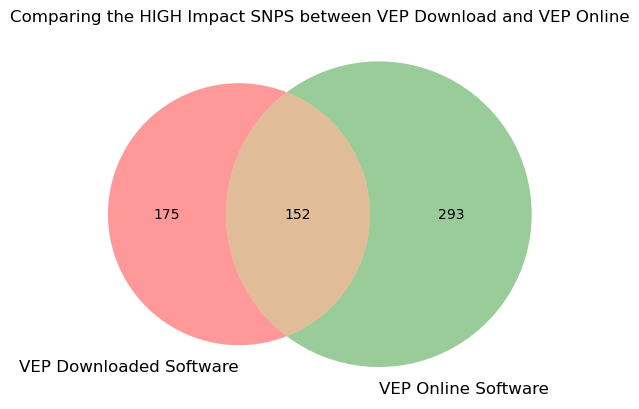

In [115]:
# Comparing all the HIGH impact snps

vepHigh = set(vep_ann[vep_ann['INFO'].str.contains('HIGH')].ID)
tAnnHigh = set(tAnn[tAnn['putative_impact']=='HIGH'].SNP)

vHigh = venn2([tAnnHigh, vepHigh], ('VEP Downloaded Software', 'VEP Online Software'))
plt.title("Comparing the HIGH Impact SNPS between VEP Download and VEP Online")
plt.show()


In [48]:
vep_lof.iloc[1].INFO

'PR;CSQ=G|intron_variant&non_coding_transcript_variant|MODIFIER|||Transcript|NM_001134425.1|cDNA||5/5||||||||rs199378794|A|A/G||-1|||||||||||||,G|stop_lost|HIGH|Aig1|292486|Transcript|XM_006227642.4|protein_coding|6/6||||1046|805|269|*/R|Tga/Cga|rs199378794|A|A/G||-1||EntrezGene|||||||||||,G|stop_lost|HIGH|Aig1|292486|Transcript|XM_039103609.1|protein_coding|5/5||||1053|703|235|*/R|Tga/Cga|rs199378794|A|A/G||-1||EntrezGene|||||||||||,G|3_prime_UTR_variant|MODIFIER|Aig1|292486|Transcript|XM_039103610.1|protein_coding|5/5||||1029|||||rs199378794|A|A/G||-1||EntrezGene|||||||||||,G|intron_variant|MODIFIER|Aig1|292486|Transcript|XM_039103611.1|protein_coding||4/4||||||||rs199378794|A|A/G||-1||EntrezGene|||||||||||,G|intron_variant|MODIFIER|Aig1|292486|Transcript|XM_039103617.1|protein_coding||4/4||||||||rs199378794|A|A/G||-1||EntrezGene|||||||||||,G|3_prime_UTR_variant|MODIFIER|Aig1|292486|Transcript|XM_039103626.1|protein_coding|4/4||||1410|||||rs199378794|A|A/G||-1||EntrezGene|||||||||||,

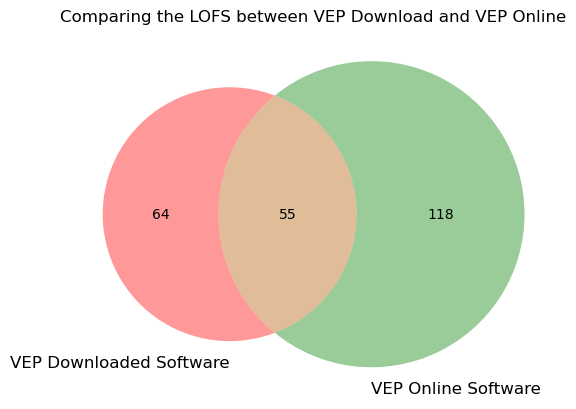

In [6]:
# Comparing all snps that have consequences: start_lost, stop_gained, stop_lost
vep_download = set(tAnnLof.SNP)
vep_online = set(vep_lof.ID)
# print(vep)

vLof = venn2([vep_download, vep_online], ('VEP Downloaded Software', 'VEP Online Software'))
plt.title("Comparing the LOFS between VEP Download and VEP Online")
plt.show()

In [8]:
len(vep_online)

173

In [6]:
same = vep_online.intersection(vep_download )
sameDF = tAnnLof[tAnnLof['SNP'].isin(same)]
sameDF
# same.to_csv('vep_intersection10.3.csv', index=False)  

,SNP,A1,A2,CHR,F_MISS,GENOTYPES,HGVS.c,HGVS.p,HWE,MAF,...,strand,bp,ACI,BN,BUF,F344,M520,MR,WKY,WN
105248,1:47264665,C,T,1,True,1433/7794/9282,XM_574311.8:c.3G>A,XP_574311.1:p.Ile1?,2.554000e-04,0.288000,...,-1,47264665,C C,C C,T T,C C,T T,T T,C C,T T
149477,1:61235370,A,T,1,True,1861/7921/8743,XM_017589926.2:c.2230T>A,XP_017445415.2:p.Ter744LysextTer9,2.828000e-01,0.314300,...,1,61235370,A A,T T,A A,T T,T T,A A,A A,T T
155796,1:63706676,T,A,1,True,7/756/17818,XM_003750425.2:c.2305A>T,XP_003750473.2:p.Arg769Ter,8.575000e-01,0.020720,...,1,63706676,A A,A A,A A,A A,A A,A A,T T,A A
194826,1:78033225,T,C,1,True,1576/7304/9681,XM_039097368.1:c.676C>T,XP_038953296.1:p.Arg226Ter,1.861000e-04,0.281700,...,1,78033225,C C,C C,C C,C C,C C,C C,T T,C C
235067,1:94378103,G,T,1,True,1981/8236/8343,NM_001005382.2:c.780A>C,NP_001005382.2:p.Ter260CysextTer?,4.442000e-01,0.328600,...,-1,94378103,T T,T T,T T,T T,G G,G G,T T,T T
236471,1:94674775,T,A,1,True,3492/9171/5895,NM_001271315.1:c.538A>T,NP_001258244.1:p.Lys180Ter,4.828000e-01,0.435300,...,1,94674775,A A,A A,T T,A A,A A,A A,A A,A A
236779,1:94757435,C,G,1,True,1983/8240/8346,XM_039097471.1:c.459C>G,XP_038953399.1:p.Tyr153Ter,4.543000e-01,0.328700,...,-1,94757435,G G,G G,G G,G G,C C,C C,G G,G G
252673,1:102666585,G,T,1,True,3049/8951/6533,XM_039100981.1:c.101C>A,XP_038956909.1:p.Ter34SerextTer?,8.670000e-01,0.406000,...,-1,102666585,T T,G G,G G,G G,G G,T T,T T,T T
281204,1:108361458,A,G,1,True,12/693/17880,NM_017295.2:c.211C>T,NP_058991.2:p.Arg71Ter,7.543000e-02,0.019290,...,-1,108361458,G G,G G,G G,G G,G G,G G,A A,G G
438390,1:159075582,G,A,1,True,955/6499/11057,NM_001000173.1:c.409C>T,NP_001000173.1:p.Ter137GlnextTer?,1.000000e+00,0.227100,...,-1,159075582,G G,G G,A A,A A,A A,A A,G G,A A


In [16]:
sameDF.columns

Index(['SNP', 'A1', 'A2', 'CHR', 'F_MISS', 'GENOTYPES', 'HGVS.c', 'HGVS.p',
       'HWE', 'MAF', 'PASS', 'PASS_HWE', 'PASS_MAF', 'PASS_MISS', 'aminoacids',
       'biotype', 'cdnaposition', 'cdsposition', 'codons', 'consequence',
       'distancetofeature', 'featureid', 'featureid_type', 'gene',
       'hgvsoffset', 'in_103', 'position_cdna|cds|protein', 'proteinposition',
       'putative_impact', 'refallele', 'source', 'strand', 'bp', 'ACI', 'BN',
       'BUF', 'F344', 'M520', 'MR', 'WKY', 'WN'],
      dtype='object')

In [7]:
geneSNP = sameDF[['SNP', 'CHR', 'consequence', 'gene', 'MAF']]
geneSNP

,SNP,CHR,consequence,gene,MAF
105248,1:47264665,1,"start_lost,start_retained_variant",RGD1560015,0.288000
149477,1:61235370,1,stop_lost,Zfp51,0.314300
155796,1:63706676,1,stop_gained,Vom2r22,0.020720
194826,1:78033225,1,stop_gained,LOC120098290,0.281700
235067,1:94378103,1,stop_lost,Klk1c12,0.328600
236471,1:94674775,1,stop_gained,Klk1c3,0.435300
236779,1:94757435,1,stop_gained,Gpr32,0.328700
252673,1:102666585,1,stop_lost,LOC102552387,0.406000
281204,1:108361458,1,"stop_gained,splice_region_variant",Gabra5,0.019290
438390,1:159075582,1,stop_lost,Or56b2k,0.227100


In [38]:
geneSNP

,SNP,CHR,consequence,gene
105248,1:47264665,1,"start_lost,start_retained_variant",RGD1560015
149477,1:61235370,1,stop_lost,Zfp51
155796,1:63706676,1,stop_gained,Vom2r22
194826,1:78033225,1,stop_gained,LOC120098290
235067,1:94378103,1,stop_lost,Klk1c12
236471,1:94674775,1,stop_gained,Klk1c3
236779,1:94757435,1,stop_gained,Gpr32
252673,1:102666585,1,stop_lost,LOC102552387
281204,1:108361458,1,"stop_gained,splice_region_variant",Gabra5
438390,1:159075582,1,stop_lost,Or56b2k


In [40]:
gene_counts_grouped

count
Other    49
4         1
2         1
Name: count, dtype: int64

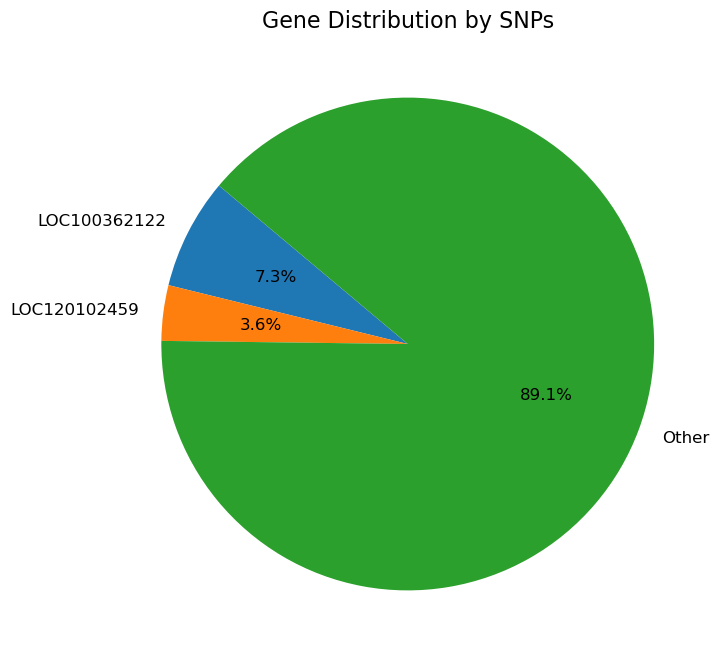

In [42]:
# Count gene occurrences
gene_counts = geneSNP['gene'].value_counts()

# Define a threshold for grouping genes into "Other"
threshold = 1
other_genes = gene_counts[gene_counts <= threshold].sum()

# Keep genes with higher frequencies
gene_counts_grouped = gene_counts[gene_counts > threshold]

# Create a new series for "Other" and concatenate
other_series = pd.Series({'Other': other_genes})
gene_counts_grouped = pd.concat([gene_counts_grouped, other_series])

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    gene_counts_grouped,
    labels=gene_counts_grouped.index,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12}
)

plt.title("Gene Distribution by SNPs", fontsize=16)
plt.show()

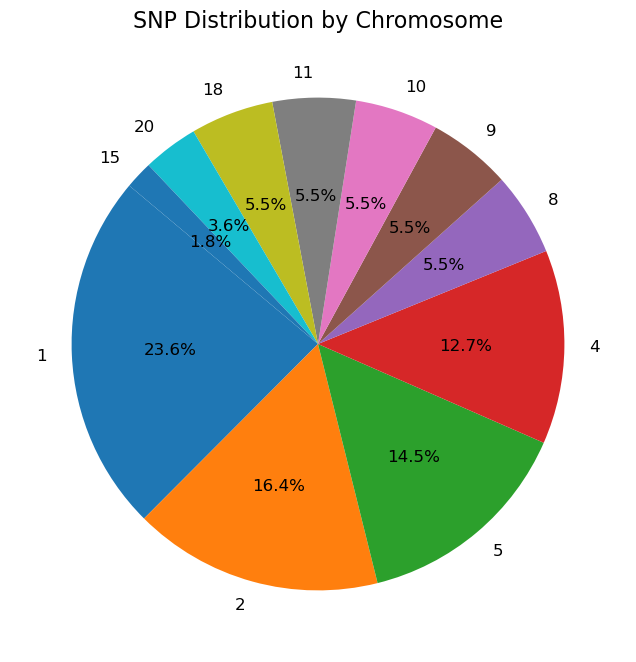

In [46]:
# Count SNPs by chromosome
chromosome_counts = geneSNP['CHR'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    chromosome_counts,
    labels=chromosome_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12}
)

plt.title("SNP Distribution by Chromosome", fontsize=16)
plt.show()

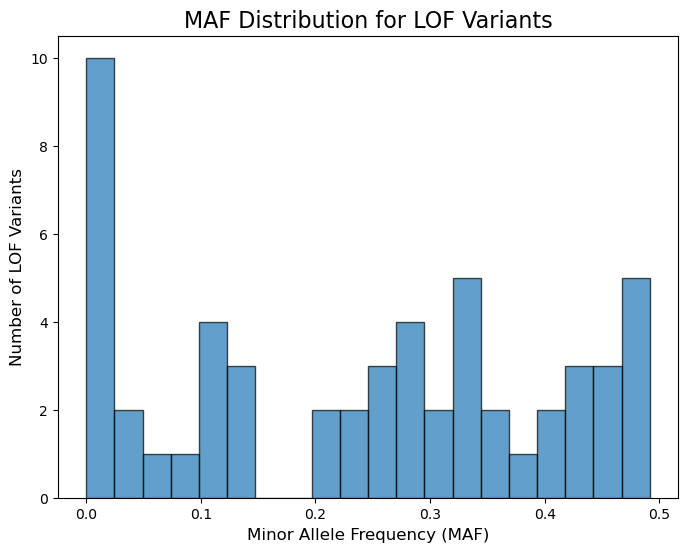

In [9]:
# Plot MAF distribution for LOF variants
plt.figure(figsize=(8, 6))
plt.hist(geneSNP['MAF'], bins=20, edgecolor='black', alpha=0.7)
plt.title("MAF Distribution for LOF Variants", fontsize=16)
plt.xlabel("Minor Allele Frequency (MAF)", fontsize=12)
plt.ylabel("Number of LOF Variants", fontsize=12)
plt.show()

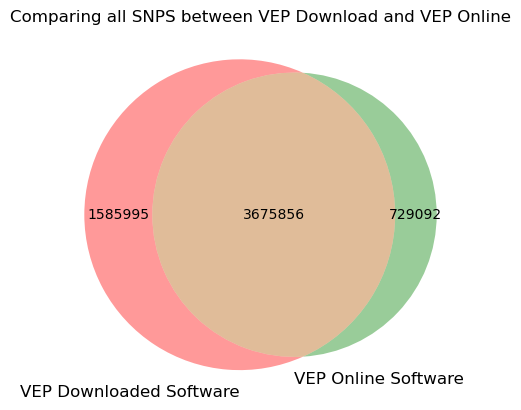

In [113]:
# Comparing all snps regardless of impact or consequence

vep_download = set(tUnwantedFiltered.SNP)
vep_online = set(vep_ann.ID)

#set drops duplicate snps

v = venn2([vep_download, vep_online], ('VEP Downloaded Software', 'VEP Online Software'))
plt.title("Comparing all SNPS between VEP Download and VEP Online")
plt.show()